In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
from torch import nn
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from pathlib import Path
from typing import Union
from ml_utilities.torch_models.base_model import BaseModel
from ml_utilities.torch_models.fc import FC
from ml_utilities.torch_models import get_model_class
from omegaconf import OmegaConf

from erank.utils import load_directions_matrix_from_task_sweep
import matplotlib.pyplot as plt
gpu_id = 0

/home/max/anaconda3/envs/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load matrix

In [2]:
p = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs'
# dir_matrix = load_directions_matrix_from_task_sweep(p, device=gpu_id)
dir_matrix = torch.normal(0,1,size=(10,1000))
dir_matrix.requires_grad_(True)

tensor([[ 3.4160e-01, -1.0696e+00,  9.8376e-02,  ..., -2.8552e-01,
          2.2654e-01, -1.4889e+00],
        [-9.4649e-01,  2.2712e-01,  1.0014e+00,  ..., -2.1174e-01,
         -1.7253e+00, -1.5291e+00],
        [-1.4818e+00,  1.3711e+00, -1.8720e+00,  ..., -2.4702e-01,
          2.0289e-01, -4.3952e-01],
        ...,
        [-1.0736e-03,  3.0866e-02,  7.4931e-04,  ..., -6.1028e-01,
         -8.1252e-01,  9.5749e-01],
        [ 4.3665e-01, -3.5078e-01, -6.5558e-01,  ...,  9.0113e-01,
          4.8965e-01, -3.2079e+00],
        [-9.1211e-01,  6.1164e-01, -1.0556e+00,  ...,  1.1844e-01,
          1.7030e+00, -7.7209e-01]], requires_grad=True)

In [3]:
dir_matrix.shape, dir_matrix.device, dir_matrix.requires_grad

(torch.Size([10, 1000]), device(type='cpu'), True)

## erank function

In [4]:
def erank(matrix_A: torch.Tensor, center_matrix_A: bool=False) -> torch.Tensor:
        """Calculates the effective rank of a matrix.

        Args:
            matrix_A (torch.Tensor): Matrix of shape m x n. 
            center_matrix_A (bool): Center the matrix 

        Returns:
            torch.Tensor: Effective rank of matrix_A
        """
        assert matrix_A.ndim == 2
        _, s, _ = torch.pca_lowrank(matrix_A, center=center_matrix_A, niter=1, q=min(matrix_A.shape[0], matrix_A.shape[1]))
        # s = torch.square(s) / (s.shape[0] - 1)

        # normalizes input s -> scale independent!
        return torch.exp(torch.distributions.Categorical(s).entropy())

In [5]:
er = erank(dir_matrix)
er

tensor(9.9834, grad_fn=<ExpBackward0>)

In [6]:
# er.backward()

## How does the gradient of the erank look like?

Context: During the experiments with erank regularized Reptile I encountered issues with Inf loss values due to (very likely) Inf gradients. 
These Inf gradients occured when we evaulated the erank at the origin. In the first inner iteration we subtract the base model from the current model parameters. This results to a zero vector.
Hypothesis: 
The erank is not continuous differentiable! Especially not at the origin. Check this.

In [7]:
norm_dir_matrix = dir_matrix / torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True)

In [8]:
# torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True), torch.linalg.norm(norm_dir_matrix, ord=2, dim=1, keepdim=True)

In [9]:
erank(dir_matrix), erank(norm_dir_matrix)

(tensor(9.9834, grad_fn=<ExpBackward0>),
 tensor(9.9864, grad_fn=<ExpBackward0>))

## How sensitive is the erank and its gradient to changes in the update vector? Specifically, the norm:

Here the erank and the singular values of the matrix = cat([pretrain_diffs, [norm_vec, 0,0, ...]]) is calculated.



In [10]:
norm_update_vec = 0.0

delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = norm_update_vec
delta.requires_grad_(True)
matrix1 = torch.cat([delta, dir_matrix], dim=0)
_, s, _ = torch.svd_lowrank(matrix1)
erank_val = erank(matrix1)
erank_val.backward()
erank_grad_norm = torch.linalg.norm(delta.grad)
s, erank_val, erank_grad_norm

(tensor([34.4444, 33.2319, 32.3715, 31.3933, 30.7054, 30.3650],
        grad_fn=<SvdHelperBackward0>),
 tensor(9.9834, grad_fn=<ExpBackward0>),
 tensor(2411965.))

In [11]:
norm_update_vec = 5.0

delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = norm_update_vec
delta.requires_grad_(True)
matrix1 = torch.cat([delta, dir_matrix], dim=0)
_, s, _ = torch.svd_lowrank(matrix1)
erank_val = erank(matrix1)
erank_val.backward()
erank_grad_norm = torch.linalg.norm(delta.grad)
s, erank_val, erank_grad_norm

(tensor([158.1568,  33.1773,  32.4182,  31.6822,  30.9266,  29.9015],
        grad_fn=<SvdHelperBackward0>),
 tensor(8.7678, grad_fn=<ExpBackward0>),
 tensor(0.0198))

The erank is sensitive to length of update vectors.

In [12]:
# This generates values for erank plots.
# It analyzes the erank of a matrix if the norm of one vector is increased.

# I use the directions matrix (i.e. concatenated models) and concatenate one vector which has only one entry. 
# This vector spans a one-dimensional space (a line). The value of this entry is increased.

def erank_sv_norm_update_vector_sweep(dir_matrix, normalize_dir_matrix: bool = False, xlim_logscale=[-3,3], n_points=30):
    dir_matrix.requires_grad_(False)
    erank_vals = []
    erank_grad_norm_vals = []
    singular_vals = []
    vec_norms = torch.logspace(xlim_logscale[0], xlim_logscale[1], n_points)
    for n in vec_norms:
        delta = torch.zeros(size=(1, dir_matrix.shape[1])).to(dir_matrix)
        delta[0] = n
        delta.requires_grad_(True)
        matrix1 = torch.cat([delta, dir_matrix], dim=0)
        if normalize_dir_matrix:
            # normalize matrix
            matrix1 = matrix1 / torch.linalg.norm(matrix1, ord=2, dim=1, keepdim=True)
        # calculate erank
        erank_val = erank(matrix1)
        erank_vals.append(erank_val.item())
        # calculate erank grad norm
        erank_val.backward()
        erank_grad_norm_vals.append(torch.linalg.norm(delta.grad).item())
        # calculate singular values
        _, s, _ = torch.svd_lowrank(matrix1)
        singular_vals.append(s.detach().cpu().numpy())
    return vec_norms, erank_vals, singular_vals, erank_grad_norm_vals


In [13]:
# make plot erank vs. appended vector norm
# def erank_vs_update_step_norm(dir_matrix, vals=20)
vec_norms, erank_vals, singular_vals, erank_grad_norm_vals = erank_sv_norm_update_vector_sweep(dir_matrix, normalize_dir_matrix=False)

(1, 90)

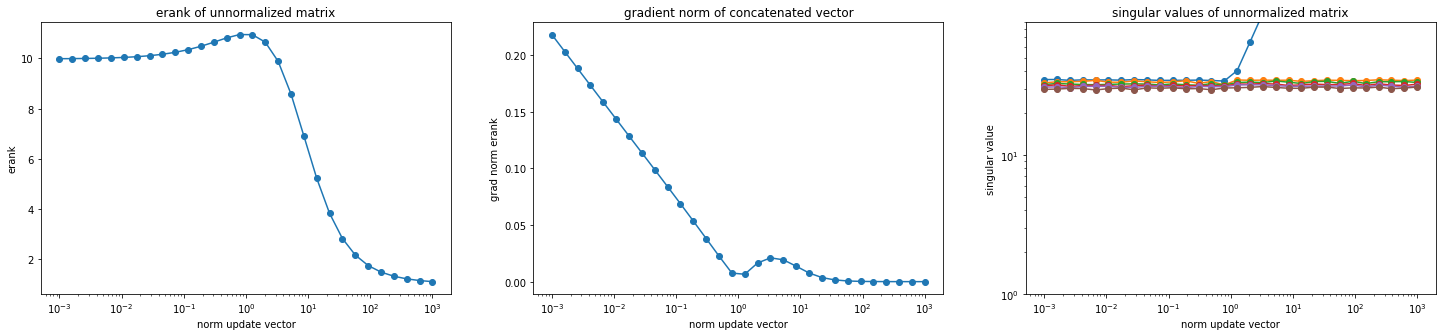

In [14]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of unnormalized matrix')

plt.subplot(1,3,2)
plt.plot(vec_norms, erank_grad_norm_vals, 'o-')
plt.xscale('log')
plt.ylabel('grad norm erank')
plt.xlabel('norm update vector')
plt.title('gradient norm of concatenated vector')

plt.subplot(1,3,3)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of unnormalized matrix')
plt.ylim(1, 90)

In [15]:
# make same plot of normalized matrix
vec_norms, erank_vals, singular_vals, erank_grad_norm_vals = erank_sv_norm_update_vector_sweep(dir_matrix, normalize_dir_matrix=True)

Text(0.5, 1.0, 'singular values of normalized matrix')

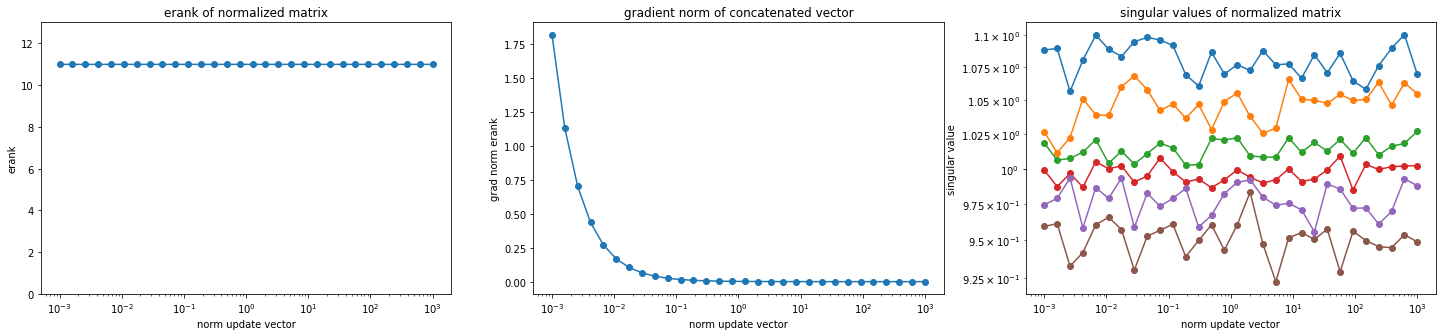

In [16]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylim(0,13)
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of normalized matrix')

plt.subplot(1,3,2)
plt.plot(vec_norms, erank_grad_norm_vals, 'o-')
plt.xscale('log')
plt.ylabel('grad norm erank')
plt.xlabel('norm update vector')
plt.title('gradient norm of concatenated vector')

plt.subplot(1,3,3)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of normalized matrix')
# plt.ylim(5, 60)


## Same analysis with unit direction matrix

This is just a sanity check if we observe the same behavior as above in a controlled setting. 

dir_matrix = cat([identity, [norm_vec,0,0,...]])

In [17]:
diag = torch.eye(10)
vec_norms, erank_vals, singular_vals, erank_grad_norm_vals = erank_sv_norm_update_vector_sweep(diag, normalize_dir_matrix=False)

Text(0.5, 1.0, 'singular values of unnormalized matrix')

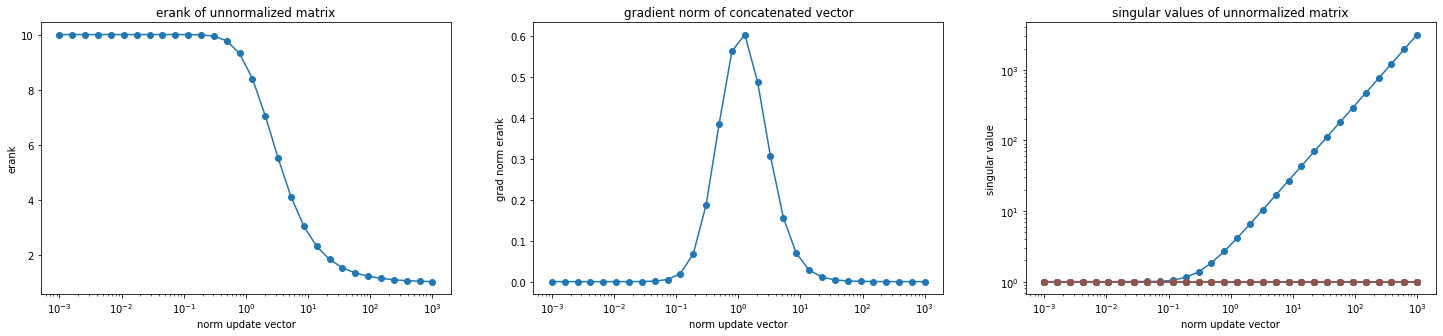

In [18]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of unnormalized matrix')

plt.subplot(1,3,2)
plt.plot(vec_norms, erank_grad_norm_vals, 'o-')
plt.xscale('log')
plt.ylabel('grad norm erank')
plt.xlabel('norm update vector')
plt.title('gradient norm of concatenated vector')

plt.subplot(1,3,3)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of unnormalized matrix')
# plt.ylim(5, 60)

In [19]:
# normalize dir matrix
diag = torch.eye(10)
vec_norms, erank_vals, singular_vals, erank_grad_norm_vals = erank_sv_norm_update_vector_sweep(diag, normalize_dir_matrix=True)

Text(0.5, 1.0, 'singular values of unnormalized matrix')

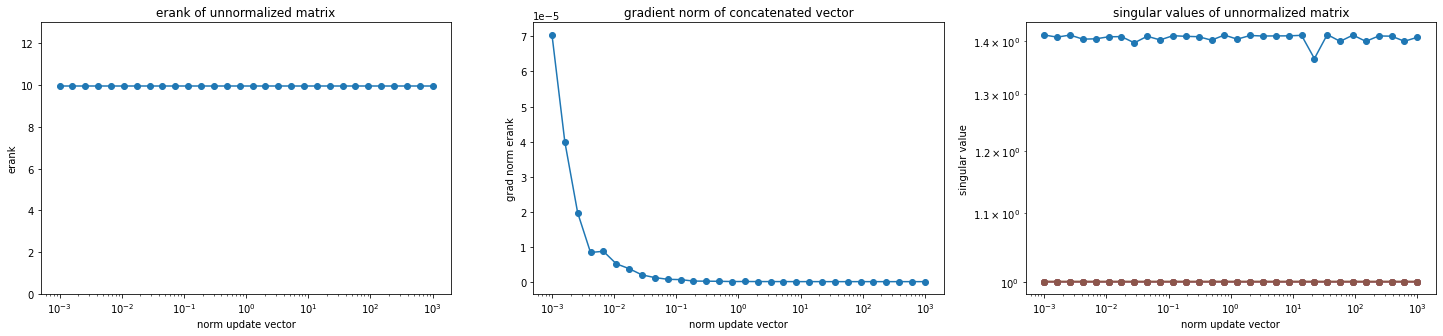

In [20]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylabel('erank')
plt.ylim(0,13)
plt.xlabel('norm update vector')
plt.title('erank of unnormalized matrix')

plt.subplot(1,3,2)
plt.plot(vec_norms, erank_grad_norm_vals, 'o-')
plt.xscale('log')
plt.ylabel('grad norm erank')
plt.xlabel('norm update vector')
plt.title('gradient norm of concatenated vector')

plt.subplot(1,3,3)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of unnormalized matrix')
# plt.ylim(5, 60)

In [21]:
# Effective rank of a diagonal matrix:
erank(diag)

tensor(10.)